# 视觉里程计
学号：23103402  
姓名：丁悦林

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import bisect
import pandas as pd

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 基于ORB的单目VO

根据txt文件中的描述“rgbd_dataset_freiburg2_desk.bag”，应该是属于TUM数据集的freiburg2系列。

所以使用tum数据集fr2系列的参数。

### 准备数据

In [38]:
# tum数据集fr2系列
# 相机内参
K = np.array([[520.9, 0.0, 325.1],
              [0.0, 521.0, 249.7],
              [0.0, 0.0, 1.0]])

# 畸变系数[k1, k2, p1, p2, k3]
dist_coef = np.array([0.2312, -0.7849, -0.0033, -0.0001, 0.9172])

In [26]:
def load_images_from_tum(path):
    """
    读取TUM数据集的 rgb.txt 文件，解析文件名并排序
    """
    rgb_txt_path = os.path.join(path, 'rgb.txt')
    image_files = []
    timestamps = []
    
    if not os.path.exists(rgb_txt_path):
        print(f"Error: {rgb_txt_path} not found.")
        return [], []
        
    with open(rgb_txt_path, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue
            parts = line.strip().split()
            if len(parts) >= 2:
                timestamp = float(parts[0])
                filename = os.path.join(path, parts[1])
                timestamps.append(timestamp)
                image_files.append(filename)
    
    return image_files, timestamps

In [27]:
dataset_path = "../data/chaoxing_data/tum"
# 加载图片列表
images, times = load_images_from_tum(dataset_path)
print(f"共加载了 {len(images)} 帧图像")

共加载了 2965 帧图像


### 流程实现

In [28]:
def detect_features(img):
    """
    使用 ORB 提取特征点和描述子
    """
    orb = cv2.ORB_create(nfeatures=3000) # 提取3000个特征点以保证鲁棒性
    kp, des = orb.detectAndCompute(img, None)
    return kp, des

def match_features(des1, des2):
    """
    使用 BFMatcher 进行特征匹配，并使用 Lowe's Ratio Test 过滤
    """
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(des1, des2, k=2)
    
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance: # 0.75 是常用的阈值
            good_matches.append(m)
            
    return good_matches

def estimate_motion(kp1, kp2, matches, K):
    """
    计算两帧之间的位姿变化 (R, t)
    """
    # 提取匹配点的坐标
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    
    # 1. 计算本质矩阵 E (RANSAC 包含在内，方法使用 cv2.RANSAC)
    # prob=0.999, threshold=1.0 (像素误差阈值)
    E, mask = cv2.findEssentialMat(pts2, pts1, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    
    if E is None or E.shape != (3, 3):
        return None, None, None
        
    # 2. 从本质矩阵恢复位姿 R, t
    _, R, t, mask_pose = cv2.recoverPose(E, pts2, pts1, K)
    
    return R, t, mask # mask用于后续可视化或统计inliers

In [29]:
# Cell 4: VO 主循环 (添加畸变校正)

def run_mono_vo(images, K, dist_coef):
    # 初始化全局位姿
    # 定义相机在世界坐标系的初始位置和姿态
    cur_R = np.eye(3)
    cur_t = np.zeros((3, 1))
    
    trajectory = [] # 存储 [x, y, z]
    trajectory.append(cur_t.flatten())
    
    # === 读取第一帧 ===
    prev_img = cv2.imread(images[0])
    if prev_img is None:
        raise ValueError("无法读取第一帧图像")
        
    # 畸变校正
    # 注意：newCameraMatrix=K 保证校正后的图像仍符合原来的内参 K
    # 这样后续 estimate_motion 时可以直接使用 K
    prev_img = cv2.undistort(prev_img, K, dist_coef, None, K)
    
    # 转灰度
    prev_gray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
    
    # 提取第一帧特征
    prev_kp, prev_des = detect_features(prev_gray)
    
    print("开始处理视频序列 (已启用畸变校正)...")
    
    # === 循环处理后续帧 ===
    for i in range(1, len(images)):
        curr_img = cv2.imread(images[i])
        
        # 畸变校正 (当前帧)
        curr_img = cv2.undistort(curr_img, K, dist_coef, None, K)
        
        curr_gray = cv2.cvtColor(curr_img, cv2.COLOR_BGR2GRAY)
        
        # 1. 特征提取
        curr_kp, curr_des = detect_features(curr_gray)
        
        # 2. 特征匹配
        if prev_des is None or curr_des is None:
            continue
        matches = match_features(prev_des, curr_des)
        
        # 3. 运动估计
        if len(matches) < 8: # 8点法求解E矩阵的最低要求
            continue
            
        R, t, mask = estimate_motion(prev_kp, curr_kp, matches, K)
        
        if R is not None:
            # ====================================================
            # 尺度问题说明：
            # 实验一中我们尚未引入GroundTruth，因此 t 是归一化的 (模长=1)
            # 这里的 absolute_scale = 1.0 意味着假设每一帧相机移动距离恒定
            # 这会导致轨迹形状正确但比例尺不对
            # ====================================================
            absolute_scale = 1.0 
            
            # 简单的防抖动处理
            if absolute_scale > 0.1: 
                # 更新全局位姿
                # 公式：t_world = t_world + R_world * (scale * t_local)
                # 公式：R_world = R_world * R_local
                cur_t = cur_t + absolute_scale * cur_R.dot(t)
                cur_R = cur_R.dot(R)
                
            trajectory.append(cur_t.flatten()) # trajectory存储位移向量[x, y, z]
            
        # 更新上一帧数据
        prev_gray = curr_gray
        prev_kp = curr_kp
        prev_des = curr_des
        
        # 打印进度
        if i % 50 == 0:
            print(f"Processing frame {i}/{len(images)} ...")
            
    return np.array(trajectory)

In [33]:
# 运行 (可以切片 images[:xxx])
traj_est = run_mono_vo(images[:500], K, dist_coef)
print("处理完成。")

开始处理视频序列 (已启用畸变校正)...
Processing frame 50/500 ...
Processing frame 100/500 ...
Processing frame 150/500 ...
Processing frame 200/500 ...
Processing frame 250/500 ...
Processing frame 300/500 ...
Processing frame 350/500 ...
Processing frame 400/500 ...
Processing frame 450/500 ...
处理完成。


In [36]:
# Cell 5: 结果可视化

def plot_trajectory(traj):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    
    # 提取 X 和 Z 坐标
    # traj 的形状是 (N, 3)，分别是 x, y, z
    x = traj[:, 0]
    z = traj[:, 2] # 也是前进方向
    
    ax.plot(x, z, label='估计的轨迹 (单目)', color='blue', linewidth=2)
    ax.set_title(f'单目视觉里程计轨迹(X-Z平面，前{len(traj)}帧)', fontsize=16)
    ax.set_xlabel('X (米) - 比例任意', fontsize=12)
    ax.set_ylabel('Z (米) - 比例任意', fontsize=12)
    ax.legend()
    ax.axis('equal') # 保证比例一致，否则形状会变形
    plt.show()

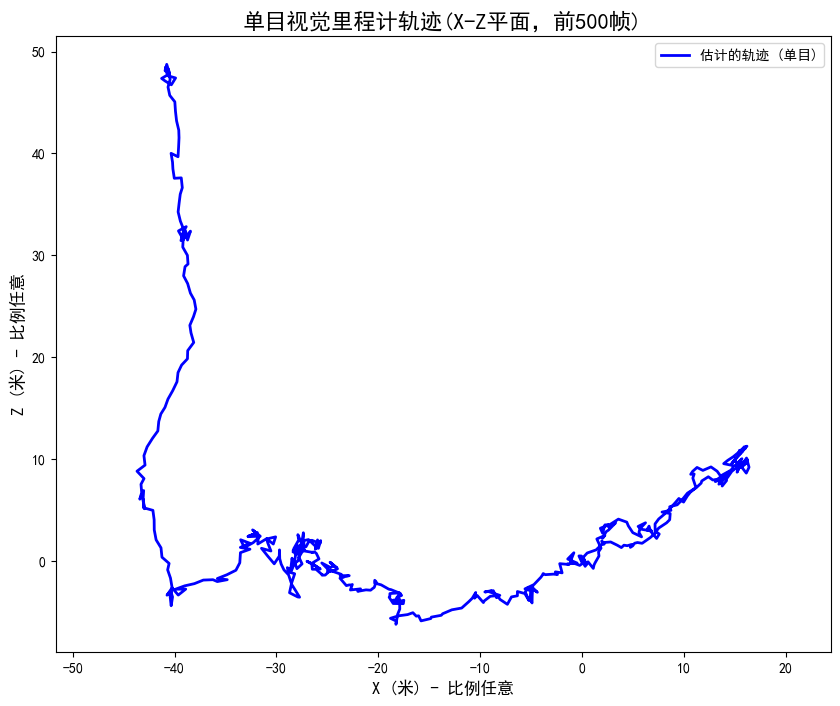

In [37]:
if len(traj_est) > 0:
    plot_trajectory(traj_est)
else:
    print("没有生成有效的轨迹。")

## RGB->GT 数据关联

In [39]:
# Cell 6: 读取 Ground Truth 数据

def load_groundtruth(dataset_path):
    """
    读取 groundtruth.txt 文件
    返回: 
        gt_data: 字典 {timestamp: [tx, ty, tz]} 
                 (为了简化，暂时只取位置，如果需要四元数也可以加上)
        gt_timestamps: 排序后的时间戳列表，用于二分查找
    """
    gt_path = os.path.join(dataset_path, 'groundtruth.txt')
    
    gt_data = {}
    gt_timestamps = []
    
    if not os.path.exists(gt_path):
        print(f"Error: {gt_path} not found.")
        return {}, []
    
    print(f"正在读取 Ground Truth: {gt_path}")
    with open(gt_path, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue
            parts = line.strip().split()
            if len(parts) >= 8: # timestamp tx ty tz qx qy qz qw
                t = float(parts[0])
                # 这里只提取位置 x, y, z
                pos = np.array([float(parts[1]), float(parts[2]), float(parts[3])])
                
                gt_data[t] = pos
                gt_timestamps.append(t)
    
    gt_timestamps.sort() # 确保有序，为了二分查找
    print(f"加载了 {len(gt_timestamps)} 条 Ground Truth 记录")
    return gt_data, gt_timestamps

In [40]:
# 加载数据
gt_dict, gt_times_list = load_groundtruth(dataset_path)

正在读取 Ground Truth: ../data/chaoxing_data/tum\groundtruth.txt
加载了 20957 条 Ground Truth 记录


In [44]:
# Cell 7: 时间戳同步 (Data Association)

def find_nearest_timestamp(target_time, sorted_times):
    """
    在有序列表 sorted_times 中找到与 target_time 最接近的时间戳
    使用 bisect 二分查找
    """
    idx = bisect.bisect_left(sorted_times, target_time)
    
    # idx 是插入位置，可能的最近邻是 idx 或 idx-1
    if idx == 0:
        return sorted_times[0]
    if idx == len(sorted_times):
        return sorted_times[-1]
    
    before = sorted_times[idx - 1]
    after = sorted_times[idx]
    
    if after - target_time < target_time - before:
        return after
    else:
        return before

def associate_data(est_timestamps, est_traj, gt_dict, gt_times_list, max_time_diff=0.02):
    """
    将估算轨迹与 GT 进行时间对齐
    """
    matched_data = []
    
    # 确保估算数据的长度一致
    assert len(est_timestamps) == len(est_traj), "时间戳与轨迹点数量不匹配"
    
    print(f"开始对齐 {len(est_timestamps)} 帧估算数据...")
    
    for i, t_rgb in enumerate(est_timestamps):
        # 1. 寻找最近的 GT 时间戳
        t_gt = find_nearest_timestamp(t_rgb, gt_times_list) # 二分查找
        
        # 2. 计算时间差
        diff = abs(t_rgb - t_gt)
        
        # 3. 阈值判定 (通常 0.02s 内认为匹配成功)
        if diff < max_time_diff:
            # 提取数据
            est_pos = est_traj[i]       # [x, y, z] 估算值
            gt_pos = gt_dict[t_gt]      # [x, y, z] 真值
            
            # 构建一行数据
            # 格式: [rgb_time, est_x, est_y, est_z, gt_time, gt_x, gt_y, gt_z]
            row = {
                'timestamp_rgb': t_rgb,
                'est_x': est_pos[0],
                'est_y': est_pos[1],
                'est_z': est_pos[2],
                'timestamp_gt': t_gt,
                'gt_x': gt_pos[0],
                'gt_y': gt_pos[1],
                'gt_z': gt_pos[2],
                'time_diff': diff
            }
            matched_data.append(row)
            
    print(f"匹配成功: {len(matched_data)} / {len(est_timestamps)} 帧")
    return pd.DataFrame(matched_data)

In [45]:
# === 执行对齐 ===
# 注意：times 是所有图片的时间戳，需要切片前 len(traj_est) 个
# 之前跑的是 images[:500]，那么 traj_est 长度就是 500，对应times[:500]

current_est_timestamps = times[:len(traj_est)]
df_matched = associate_data(current_est_timestamps, traj_est, gt_dict, gt_times_list)

# 显示前5行预览
df_matched.head()

开始对齐 500 帧估算数据...
匹配成功: 450 / 500 帧


,timestamp_rgb,est_x,est_y,est_z,timestamp_gt,gt_x,gt_y,gt_z,time_diff
0,1.311868e+09,0.000000,0.000000,0.000000,1.311868e+09,-0.1546,-1.4445,1.4773,0.000019
1,1.311868e+09,0.307506,-0.793291,-0.525480,1.311868e+09,-0.1578,-1.4458,1.4770,0.000774
2,1.311868e+09,0.582658,-1.644854,-0.079239,1.311868e+09,-0.1601,-1.4472,1.4767,0.001140
3,1.311868e+09,1.098858,-2.202891,-0.728955,1.311868e+09,-0.1633,-1.4501,1.4766,0.000145
4,1.311868e+09,1.176567,-3.137807,-0.382699,1.311868e+09,-0.1660,-1.4525,1.4765,0.000670


In [46]:
# Cell 8: 保存对齐结果到 CSV

output_csv_name = 'tum_rgb_to_gt.csv'
if not df_matched.empty:
    # 保存列
    cols_to_save = ['timestamp_rgb', 'est_x', 'est_y', 'est_z', 'timestamp_gt',
                    'gt_x', 'gt_y', 'gt_z', 'time_diff']
    
    df_matched[cols_to_save].to_csv(output_csv_name, index=False)
    print(f"实验二结果已保存至: {os.path.abspath(output_csv_name)}")

实验二结果已保存至: e:\Python_Project\camera_calibrate\Camera_Calibrate\code\tum_rgb_to_gt.csv
